<a href="https://colab.research.google.com/github/elangbijak4/Humanoid-Robot/blob/main/Demo1%20-%201%20Agen%20ke%201%20Join%20Sendi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/800, loss=0.990043
Epoch 101/800, loss=0.557261
Epoch 201/800, loss=0.551307
Epoch 301/800, loss=0.543594
Epoch 401/800, loss=0.532540
Epoch 501/800, loss=0.515563
Epoch 601/800, loss=0.488199
Epoch 701/800, loss=0.444475
Epoch 800/800, loss=0.381654
Final error ANN: 2.2753 after 400 steps
Final error Jacobian: 0.0198 after 162 steps


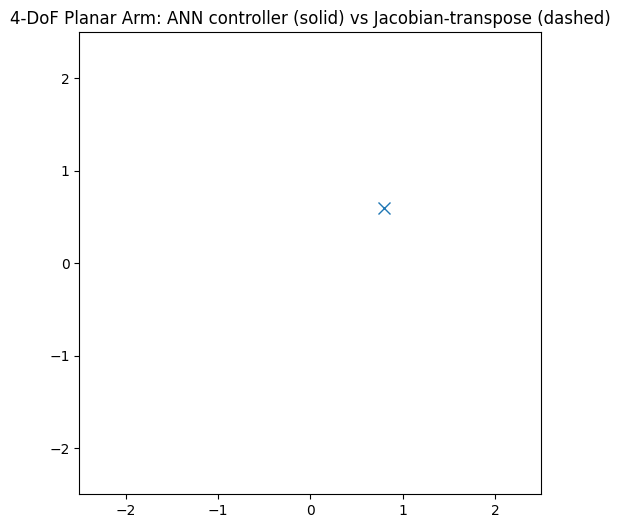

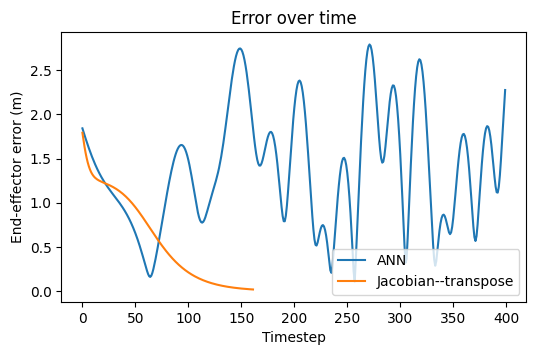

Demo complete. You can re-run training with different hyperparameters or target positions.


In [1]:
# 4-DoF planar arm Colab demo
# - ANN (numpy MLP) dilatih untuk meniru Jacobian-transpose controller
# - Animasi matplotlib menampilkan ANN (solid) vs Jacobian-transpose (dashed)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

np.random.seed(42)

# --- Robot kinematics (4-DoF planar arm) ---
DOF = 4
LINKS = np.array([0.8, 0.6, 0.5, 0.4])  # link lengths -> total reach ~2.3
assert LINKS.shape[0] == DOF

def forward_kinematics(q):
    """
    q: shape (..., DOF)
    returns: end-effector x,y (...,2) and joint positions shape (..., DOF+1, 2) (including base)
    """
    qs = np.cumsum(q, axis=-1)
    x = np.cumsum(np.cos(qs) * LINKS, axis=-1)
    y = np.cumsum(np.sin(qs) * LINKS, axis=-1)
    pts = np.stack([x, y], axis=-1)  # (..., DOF, 2)
    origin = np.zeros_like(pts[..., :1, :])  # (...,1,2)
    joints = np.concatenate([origin, pts], axis=-2)  # (..., DOF+1, 2)
    ee = joints[..., -1, :]
    return ee, joints

def jacobian(q):
    """
    Compute Jacobian for planar serial arm.
    q: shape (DOF,)
    returns: 2 x DOF Jacobian
    """
    J = np.zeros((2, DOF))
    angles = np.cumsum(q)
    for i in range(DOF):
        s = np.sum(np.sin(angles[i:]) * LINKS[i:])
        c = np.sum(np.cos(angles[i:]) * LINKS[i:])
        # Partial derivatives of x and y wrt q_i
        J[0, i] = -s
        J[1, i] = c
    return J

# --- Jacobian-transpose controller used to generate training targets ---
def jacobian_transpose_control(q, target, alpha=1.0):
    ee, _ = forward_kinematics(q[None, :])
    ee = ee[0]
    error = target - ee
    J = jacobian(q)
    qdot = alpha * J.T.dot(error)  # simple proportional via Jacobian transpose
    # clamp velocities to avoid huge steps
    max_vel = 2.0
    qdot = np.clip(qdot, -max_vel, max_vel)
    return qdot

# --- Dataset generation (supervised imitation of Jacobian-transpose) ---
def generate_dataset(n_samples=5000):
    Q = np.random.uniform(-np.pi/2, np.pi/2, size=(n_samples, DOF))
    # targets in workspace around origin
    angles = np.random.uniform(0, 2*np.pi, size=(n_samples,))
    radii = np.random.uniform(0.2, LINKS.sum()*0.95, size=(n_samples,))
    T = np.stack([radii*np.cos(angles), radii*np.sin(angles)], axis=-1)
    # compute qdot using Jacobian-transpose
    QDOT = np.array([jacobian_transpose_control(q, t, alpha=0.8) for q,t in zip(Q,T)])
    X = np.concatenate([Q, T], axis=-1)  # input: q (DOF) + target (2)
    Y = QDOT  # output velocities (DOF)
    return X, Y

# generate dataset
X, Y = generate_dataset(n_samples=3000)

# --- Simple MLP implemented in numpy ---
class MLP:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Xavier init
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2/(input_dim+hidden_dim))
        self.b1 = np.zeros((hidden_dim,))
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2/(hidden_dim+output_dim))
        self.b2 = np.zeros((output_dim,))
    def forward(self, x):
        z1 = x.dot(self.W1) + self.b1
        a1 = np.tanh(z1)
        z2 = a1.dot(self.W2) + self.b2
        # output is linear (velocities)
        return z1, a1, z2
    def predict(self, x):
        _, _, z2 = self.forward(x)
        return z2
    def train(self, X, Y, epochs=1000, lr=1e-3, batch=64, verbose=True):
        n = X.shape[0]
        losses = []
        for ep in range(epochs):
            perm = np.random.permutation(n)
            Xs = X[perm]
            Ys = Y[perm]
            epoch_loss = 0.0
            for i in range(0, n, batch):
                xb = Xs[i:i+batch]
                yb = Ys[i:i+batch]
                z1, a1, ypred = self.forward(xb)
                err = ypred - yb
                loss = np.mean(err**2)
                epoch_loss += loss * xb.shape[0]
                # backprop
                dloss = 2 * err / xb.shape[0]  # shape batch x output
                dW2 = a1.T.dot(dloss)
                db2 = dloss.sum(axis=0)
                da1 = dloss.dot(self.W2.T)
                dz1 = da1 * (1 - np.tanh(z1)**2)
                dW1 = xb.T.dot(dz1)
                db1 = dz1.sum(axis=0)
                # gradient step
                self.W2 -= lr * dW2
                self.b2 -= lr * db2
                self.W1 -= lr * dW1
                self.b1 -= lr * db1
            epoch_loss /= n
            losses.append(epoch_loss)
            if verbose and (ep % 100 == 0 or ep==epochs-1):
                print(f"Epoch {ep+1}/{epochs}, loss={epoch_loss:.6f}")
        return losses

# create and train network
input_dim = DOF + 2
hidden_dim = 64
output_dim = DOF
net = MLP(input_dim, hidden_dim, output_dim)
losses = net.train(X, Y, epochs=800, lr=5e-4, batch=128, verbose=True)

# --- Demo: animate arm controlled by ANN to reach a target ---
def run_episode(initial_q, target, controller, dt=0.05, steps=200):
    qs = []
    errors = []
    q = initial_q.copy()
    for _ in range(steps):
        inp = np.concatenate([q, target])[None, :]
        qdot = controller(inp)[0]
        # integrate with simple Euler
        q = q + qdot * dt
        qs.append(q.copy())
        ee, _ = forward_kinematics(q[None, :])
        err = np.linalg.norm(target - ee[0])
        errors.append(err)
        if err < 0.02:
            break
    return np.array(qs), np.array(errors)

# ANN controller wrapper
def ann_controller(x):
    return net.predict(x)

# Simple jacobian controller wrapper for comparison
def jac_controller_batch(x):
    # x: batch x (DOF+2)
    outs = []
    for row in x:
        q = row[:DOF]
        t = row[DOF:]
        outs.append(jacobian_transpose_control(q, t, alpha=0.8))
    return np.array(outs)

# Prepare demo initial state and target
initial_q = np.random.uniform(-0.5, 0.5, size=(DOF,))
# choose a reachable target
target = np.array([0.8, 0.6])

qs_ann, errs_ann = run_episode(initial_q, target, ann_controller, dt=0.05, steps=400)
qs_jac, errs_jac = run_episode(initial_q, target, jac_controller_batch, dt=0.05, steps=400)

print(f"Final error ANN: {errs_ann[-1]:.4f} after {len(errs_ann)} steps")
print(f"Final error Jacobian: {errs_jac[-1]:.4f} after {len(errs_jac)} steps")

# --- Animation of result: show ANN-controlled arm reaching the target ---
ee_ann, joints_ann = forward_kinematics(qs_ann)
ee_jac, joints_jac = forward_kinematics(qs_jac)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', 'box')
ax.set_xlim(-sum(LINKS)-0.2, sum(LINKS)+0.2)
ax.set_ylim(-sum(LINKS)-0.2, sum(LINKS)+0.2)
ax.set_title('4-DoF Planar Arm: ANN controller (solid) vs Jacobian-transpose (dashed)')
target_plot, = ax.plot([target[0]], [target[1]], marker='x', markersize=8)
# ANN lines
line_ann, = ax.plot([], [], linewidth=3)
pts_ann, = ax.plot([], [], marker='o', linestyle='')  # joint markers
# Jacobian dashed
line_jac, = ax.plot([], [], linestyle='--', linewidth=2)
pts_jac, = ax.plot([], [], marker='s', linestyle='')  # joint markers

max_frames = max(len(qs_ann), len(qs_jac))

def init():
    line_ann.set_data([], [])
    pts_ann.set_data([], [])
    line_jac.set_data([], [])
    pts_jac.set_data([], [])
    return line_ann, pts_ann, line_jac, pts_jac, target_plot

def update(i):
    # ANN
    idx_ann = min(i, len(qs_ann)-1)
    _, joints_a = forward_kinematics(qs_ann[idx_ann][None,:])
    ja = joints_a[0]
    line_ann.set_data(ja[:,0], ja[:,1])
    pts_ann.set_data(ja[:,0], ja[:,1])
    # Jacobian
    idx_jac = min(i, len(qs_jac)-1)
    _, joints_j = forward_kinematics(qs_jac[idx_jac][None,:])
    jj = joints_j[0]
    line_jac.set_data(jj[:,0], jj[:,1])
    pts_jac.set_data(jj[:,0], jj[:,1])
    return line_ann, pts_ann, line_jac, pts_jac, target_plot

anim = animation.FuncAnimation(fig, update, frames=max_frames, init_func=init, interval=40, blit=True)
plt.show()

# Also plot error over time for both controllers (separate figure per instructions)
fig2, ax2 = plt.subplots(figsize=(6,3.5))
ax2.plot(errs_ann, label='ANN')
ax2.plot(errs_jac, label='Jacobian--transpose')
ax2.set_xlabel('Timestep')
ax2.set_ylabel('End-effector error (m)')
ax2.set_title('Error over time')
ax2.legend()
plt.show()

print("Demo complete. You can re-run training with different hyperparameters or target positions.")
